# **Homework 2: Image segmentation without user input**

## Overview
This homework has two parts.

The first part of this homework is to implement [Grad-CAM](https://arxiv.org/pdf/1610.02391) – a method for producing saliency maps (heatmaps of regions that are most relevant to a model) that uses both activations and gradients of the feature maps of a convolutional layer. Feature maps of deeper convolutional layers represent more high-level features, while preserving rough spatial structure, which makes them a good candidate for explaining a model's output.

The second part of this homework is to use SAM for image segmentation without user input.
SAM [(Segment Anything Model v1)](https://arxiv.org/pdf/2304.02643) is a popular family of open-weight models for image segmentation (based on the vision transformer ViT and CLIP).
The model takes as input an image to be segmented and additionaly bounding boxes, point coordinates etc. clarifying the object of interest to be segmented. It can output many proposed segmentations of many objects on one image. Your task will be to find appropriate point coordinates automatically, so that SAM can be used with just an image input to segment particular objects.

---

## Dataset

You will use a small custom dataset based on [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10), but containing images with one of five objects (circle, square, diamond, triangle, star), with ground-truth segmentations of that object.

---

## GradCAM task

For the first task:
* Read the original [Grad-CAM](https://arxiv.org/pdf/1610.02391) paper.
* Implement it, without using non-standard packages (the only imports allowed are built-ins, torch, torchvision, numpy, scipy, and helpers like cv2, PIL, tqdm, matplotlib).
* The result should be a class named `GradCAM` with methods:
    * `def __init__(model: nn.Module, target_layers=Iterable[nn.Module])`
    * `def __call__(self, image: Tensor, targets: Iterable[int] | None = None) -> np.ndarray` where
        * `image` is an input to `model` (a normalized batch of shape `B,C,H,W`).
        * `targets` is an iterable of target classes that we want to segment; if None is given, use the top class predicted by the model.
        * The result is a numpy array of shape (B, H, W) containing the GradCam heatmap, with `min..max` values rescaled to `0..1` (independently for each image in the batch and each `target_layers`). If more than one `target_layers` was given, return the average of the resulting heatmaps.      
    * Feel free to add optional/default arguments and additional methods.
* Check your implementation by running the code under the `GradCAM results` header.

Tip: you may find it particularly useful to use: [nn.Module.register_full_backward_hook](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook).


## Segmentation task

For the second part, SAM is given as a black-box. You must design a pipeline that takes only an image and outputs a segmentation of the circle/square/diamond/triangle/star shape. The input to SAM should be the image and coordinates of point(s) that are likely to be inside ("foreground") or likely to be outside ("background") of the shape. **The coordinates must be the output of the previous step of the pipeline. They cannot be provided directly by user.**

* Think of a way to find appropriate points. Try two different approaches:
    1. at least one foreground point, without background points.
    2. at least one foreground point and at least one background point.
* Implement both approches as subclasses of `BasicSamPipeline`, overriding the `__call__` method (preserving the signature).
* Evaluate your generated point(s) and report the following metrics:
    * *hit rate*: how often they fall inside the ground-truth mask;
    * *distance*: distance from the center of mass of the ground-truth mask
        (the average coordinate of True pixels in the mask).
* Evaluate your overall pipeline and report the following metric:
    * *Intersection over Union (IoU)* of the predicted and ground-truth masks, averaged over all images in the dataset.


**Important**: This task is not about finding the pipeline with best hyperparameters; we expect an IoU of at least `65%`, but achieving results higher than that will not affect the grade for the assignment.

**Important**: Do not train or fine-tune your own models, only use the ones provided (the classifier and SAM).

---

## Deliverables

On [Moodle](https://moodle.mimuw.edu.pl/mod/assign/view.php?id=159965), submit a .zip archive with:

1. **Notebook** (`.ipynb`):
    * It should contain:
        * The GradCAM implementation.
        * The two `BasicSamPipeline` subclasses.
        * Evaluations with computations of all reported metrics.
    * It should be possible to execute the whole notebook start-to-end without human intervention.
    * Such an execution should take less than 30 minutes on a Colab GPU.
    * Do not modify (but *do* execute) cells under headers marked as `[do not modify]`. If you wish to extend them (e.g. to check more GradCAM results), you may do so **under a new header**.

2. **Report (1-2 pages, PDF)** including:
   * An examplary visualization of the output of the Grad-CAM
   * A concise description of each approach for the SAM pipelines (1-3 sentences each).
   * A presentation of all metrics.
   * Discussion (up to 5 sentences) on potential areas for improvements.

3. **README.md**:
   * Link to Colab version of the notebook for fast replication.



## Grading

1. Implementation correctness of Grad-CAM:  30%
2. Implementation correctness of the multistage pipeline and evaluations: 50%
3. Report & analysis: 20%

Please take care of readability, clear structure in particular (headers in notebooks, modular code).
This will be considered within each grading component.



# 0. Preliminaries

## Imports

In [1]:
# !pip install torch torchvision matplotlib opencv-python-headless numpy segment-anything

In [2]:
import os
import random
from collections.abc import Callable, Iterable
from pathlib import Path
from typing import Any, Final, Literal, TypedDict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.ndimage
import torch
import torch.nn.functional as F
import torchvision.models
from torch import Tensor, nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from tqdm import tqdm

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

## Dataset [do not modify]

CIFAR-10 download takes 170 MiB.

In [4]:
%%bash --no-raise-error
mkdir -p data/
wget -nc -q -O data/synthetic_shapes.zip https://www.mimuw.edu.pl/~mwrochna/upload/synthetic_shapes.zip
unzip -d data/ data/synthetic_shapes.zip &> /dev/null

In [5]:
class SyntheticData[T](Dataset):
    """A small synthetic segmentation dataset.

    It is a sequence dataset of 5000 tuples (image, class, mask), where:
    - image: before transformation, an RGB PIL Image.
    - class: int 0..4, the label index.
    - mask:  numpy array of dtype=bool, shape (H, W), same size as image.
    """

    CLASSES: Final[tuple[str, ...]] = ("circle", "square", "triangle", "star", "diamond")

    def __init__(
        self,
        path: Path,
        split: Literal["train", "val", "test"],
        transform: Callable[[PIL.Image.Image], T],
    ) -> None:
        self.path = path
        self.transform = transform
        self.split = split

        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.CLASSES)}

        images = sorted((self.path / "images" / self.split).glob("*.png"))
        masks = sorted((self.path / "masks" / self.split).glob("*.png"))
        labels = sorted((self.path / "labels" / self.split).glob("*.txt"))

        assert images, f"No images found in {self.path / 'images' / self.split}"
        assert len(images) == len(masks) == len(labels), (
            "Number of images, masks, and labels must be the same"
        )
        assert [p.stem for p in images] == [p.stem for p in masks] == [p.stem for p in labels], (
            "Image/mask/label filename mismatch."
        )
        self.image_names = [p.stem for p in images]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, idx) -> tuple[T, int, np.ndarray]:
        name = self.image_names[idx]
        img_path = self.path / "images" / self.split / f"{name}.png"
        mask_path = self.path / "masks" / self.split / f"{name}.png"
        label_path = self.path / "labels" / self.split / f"{name}.txt"

        img = PIL.Image.open(img_path).convert("RGB")
        mask = np.array(PIL.Image.open(mask_path), dtype=bool)
        label = self.class_to_idx[label_path.read_text().strip()]

        img_transformed: T = self.transform(img)

        return img_transformed, label, mask


def show_image_row(
    image_dict: dict[str, PIL.Image.Image | np.ndarray | Tensor], size: float = 3.0
) -> None:
    n = len(image_dict)
    _, axs = plt.subplots(1, n, figsize=(size * n, size), constrained_layout=True, squeeze=True)
    if n == 1:
        axs = [axs]
    for ax, (title, img) in zip(axs, image_dict.items(), strict=True):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.show()

train dataset size: 3500
val dataset size: 1000
test dataset size: 500


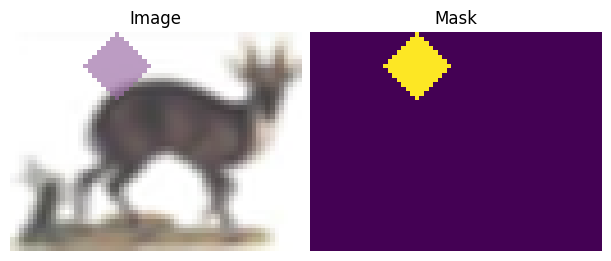

Label: 4 (diamond)


In [6]:
dataset_path = Path("./data/synthetic_shapes")


def example_from_dataset(idx: int = 3):
    for split in ("train", "val", "test"):
        dataset = SyntheticData(dataset_path, split=split, transform=lambda x: x)
        print(f"{split} dataset size: {len(dataset)}")

    img, label, mask = dataset[idx]
    show_image_row({"Image": img, "Mask": mask})
    print(f"Label: {label} ({SyntheticData.CLASSES[label]})")


example_from_dataset()

## Training a classifier [do not modify]

In [7]:
def train(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int = 5,
    **optimizer_kwargs: Any,
) -> None:
    print(f"🚀 Training CNN for {epochs} epochs...")
    optimizer = optim.AdamW(model.parameters(), **optimizer_kwargs)

    for epoch in range(epochs):
        _train_epoch(model, train_loader, optimizer, desc=f"Epoch {epoch + 1}/{epochs} training  ")
        val_metrics = evaluate(model, val_loader, desc=f"Epoch {epoch + 1}/{epochs} validation")
        print(
            f"Epoch {epoch + 1}/{epochs} — "
            + f"val loss: {val_metrics['loss']:.3f}, val acc: {val_metrics['accuracy']:.1%}"
        )

    test_metrics = evaluate(model, test_loader, desc="Test Evaluation")
    print(
        "✅ Model training complete: "
        + f"Test loss: {test_metrics['loss']:.3f}, test acc: {test_metrics['accuracy']:.1%}"
    )


def _train_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: optim.Optimizer,
    desc: str,
) -> dict[str, float]:
    model.train()
    device = next(model.parameters()).device
    total_loss = 0
    total_correct = 0
    total_samples = 0
    progress_bar = tqdm(dataloader, desc=desc)
    for imgs, labels, _ in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.shape[0]
        total_correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(
            train_loss=f"{total_loss / (total_samples / labels.shape[0]):.3f}",
            train_acc=f"{total_correct / total_samples:.1%}",
        )

    return {"loss": total_loss / len(dataloader), "accuracy": total_correct / total_samples}


def evaluate(
    model: nn.Module, dataloader: torch.utils.data.DataLoader, desc: str
) -> dict[str, float]:
    model.eval()
    device = next(model.parameters()).device
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for imgs, labels, _mask in tqdm(dataloader, desc=desc):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1)
            total_samples += labels.shape[0]
            total_correct += (predicted == labels).sum().item()

    return {"loss": total_loss / len(dataloader), "accuracy": total_correct / total_samples}


class DataloaderArgs(TypedDict, total=False):
    batch_size: int
    shuffle: bool
    num_workers: int
    pin_memory: bool

In [8]:
device = torch.accelerator.current_accelerator(check_available=True) or torch.device("cpu")
use_accel = device != torch.device("cpu")
print(use_accel, device)

True cuda


In [9]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
inverse_transform = v2.Compose(
    [
        v2.Normalize(
            [-m / s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD, strict=True)],
            [1 / s for s in IMAGENET_STD],
        ),
        v2.ToPILImage(),
    ]
)

train_dataset = SyntheticData(dataset_path, transform=transform, split="train")
val_dataset = SyntheticData(dataset_path, transform=transform, split="val")
test_dataset = SyntheticData(dataset_path, transform=transform, split="test")

train_kwargs: DataloaderArgs = {
    "batch_size": 128,
    "num_workers": 2,
    "shuffle": True,
    "pin_memory": use_accel,
}
val_kwargs: DataloaderArgs = {"batch_size": 500, "num_workers": 2, "pin_memory": use_accel}
test_kwargs: DataloaderArgs = val_kwargs

train_loader = DataLoader(train_dataset, **train_kwargs)
val_loader = DataLoader(val_dataset, **val_kwargs)
test_loader = DataLoader(test_dataset, **test_kwargs)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print("✅ DataLoaders created for train, validation, and test sets.")

Train dataset size: 3500
Validation dataset size: 1000
Test dataset size: 500
✅ DataLoaders created for train, validation, and test sets.


In [10]:
checkpoint_path = Path("./model_checkpoint.pth")

model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(SyntheticData.CLASSES))
# We have less classes, so we replace the final layer, but keep the rest
# (since the model learned useful features like shape etc.)
model = model.to(device)

if not checkpoint_path.exists():
    train(model, train_loader, val_loader, test_loader, epochs=5, lr=2e-3, weight_decay=0.05)
    torch.save(model.state_dict(), checkpoint_path)
else:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
    metrics = evaluate(model, test_loader, desc="Test Evaluation")
    print()
    print(
        "✅ Model loaded from checkpoint: "
        + f"Test loss: {metrics['loss']:.3f}, test acc: {metrics['accuracy']:.1%}"
    )

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


🚀 Training CNN for 5 epochs...


Epoch 1/5 validation: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 1/5 — val loss: 1.351, val acc: 51.7%


Epoch 2/5 validation: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Epoch 2/5 — val loss: 0.371, val acc: 85.4%


Epoch 3/5 validation: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch 3/5 — val loss: 0.294, val acc: 89.8%


Epoch 4/5 validation: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


Epoch 4/5 — val loss: 0.546, val acc: 83.7%


Epoch 5/5 validation: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Epoch 5/5 — val loss: 0.533, val acc: 86.4%


Test Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

✅ Model training complete: Test loss: 0.407, test acc: 89.6%


# 1. GradCAM

In [11]:
#scratchpad
print(train_loader.batch_size)

128


In [12]:
#scratchpad
batch = next(iter(train_loader))
print(len(batch))
print(batch[0].shape) # images
print(batch[1].shape) # labels
print(batch[2].shape) # masks

3
torch.Size([128, 3, 48, 64])
torch.Size([128])
torch.Size([128, 48, 64])


In [13]:
#scratchpad
images, labels, masks = next(iter(train_loader))

In [14]:
#scratchpad
y = model(images[:1].to(device))
print(y.shape)
print("logits:", y[0])
correct_class = torch.argmax(y, dim=1)
print("correct class:", correct_class)
model.zero_grad()
y[0, correct_class].backward(retain_graph=True)
print(y[0, correct_class])

torch.Size([1, 5])
logits: tensor([ 1.6098, -2.3412, -2.6428,  3.6017,  0.8311], device='cuda:0',
       grad_fn=<SelectBackward0>)
correct class: tensor([3], device='cuda:0')
tensor([3.6017], device='cuda:0', grad_fn=<IndexBackward0>)


In [15]:
#scratchpad
print(batch[1])

tensor([4, 2, 2, 2, 0, 4, 4, 4, 2, 0, 2, 2, 1, 3, 0, 0, 1, 0, 3, 3, 1, 4, 0, 2,
        2, 0, 4, 0, 1, 3, 0, 2, 4, 0, 2, 2, 4, 4, 1, 0, 1, 2, 4, 2, 4, 1, 1, 2,
        3, 2, 4, 4, 0, 3, 1, 3, 1, 4, 0, 1, 4, 1, 0, 1, 1, 0, 4, 3, 1, 0, 3, 4,
        0, 1, 3, 3, 0, 0, 0, 2, 0, 1, 0, 4, 2, 2, 4, 4, 1, 1, 0, 2, 0, 1, 4, 0,
        3, 4, 3, 1, 4, 4, 1, 3, 3, 2, 4, 2, 1, 2, 2, 2, 0, 4, 1, 3, 3, 4, 4, 4,
        4, 2, 4, 3, 3, 2, 0, 2])


In [16]:
#scratchpad
def hook_fn(module, input, output):
    print("Test")

model.layer4.register_full_backward_hook(hook_fn)

In [17]:
#scratchpad
print(model.layer4)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [18]:
#scratchpad
print(model.fc)
print(model.fc.weight)
print(model.fc.weight.shape)

Linear(in_features=512, out_features=5, bias=True)
Parameter containing:
tensor([[-0.0009,  0.0107,  0.0016,  ...,  0.0327, -0.0252, -0.0125],
        [-0.0333, -0.0037,  0.0301,  ...,  0.0176,  0.0015, -0.0006],
        [-0.0156, -0.0406, -0.0044,  ...,  0.0038,  0.0183, -0.0167],
        [ 0.0260, -0.0182, -0.0050,  ...,  0.0063,  0.0064, -0.0245],
        [-0.0099,  0.0128,  0.0200,  ...,  0.0351, -0.0172,  0.0123]],
       device='cuda:0', requires_grad=True)
torch.Size([5, 512])


In [19]:
#scratchpad
gradients = model.fc.weight[:, correct_class]
print(gradients.shape)

torch.Size([5, 1])


## GradCAM implementation (add your code)

In [20]:
from functools import partial
import torch.nn.functional as F

class GradCAM:
    """
    Pure PyTorch implementation of Grad-CAM.

    Usage:
        grad_cam = GradCAM(model=model, target_layers=[layer1, layer2])
        grayscale_cam = grad_cam(input_tensor, targets=[class_id])
    """

    def __init__(self, model: nn.Module, target_layers: Iterable[nn.Module]) -> None:
      """
        Args:
            model: The neural network model
            target_layers: Layers to compute Grad-CAM for.
            If more than one target_layers was given, returns the average
            of the resulting heatmaps.
      """
      self.model = model
      self.target_layers = target_layers

      self.activations = [None] * len(target_layers)
      self.gradients = [None] * len(target_layers)
      self.forward_hooks = [] # activation hooks
      self.backward_hooks = [] # gradient hooks

      for i, layer in enumerate(self.target_layers):
          act_hook_fn = partial(self.save_activation, i)
          self.forward_hooks.append(layer.register_forward_hook(act_hook_fn))
          grad_hook_fn = partial(self.save_gradient, i)
          self.backward_hooks.append(layer.register_full_backward_hook(grad_hook_fn))

    def save_activation(self, i, _module, _act_input, act_output):
        """
        Forward hook to capture layer activations.

        Args:
            i: Index of the target layer
            _module: The layer itself
            _act_input: 1-tuple of inputs to the layer
            act_output: The layer's output tensor
        """
        self.activations[i] = act_output.detach()

    def save_gradient(self, i, _module, _grad_input, grad_output):
        """
        Backward hook to capture gradients.

        Args:
            i: Index of the target layer
            _module: The layer itself
            _grad_input: 1-tuple of gradients w.r.t. the layer's inputs
            grad_output: 1-tuple of gradients w.r.t. the layer's outputs (usually single element)
        """
        self.gradients[i] = grad_output[0].detach()

    def clear_saved_data(self):
        """
        Clears the saved activations and gradients.
        """
        self.activations = [None] * len(self.target_layers)
        self.gradients = [None] * len(self.target_layers)

    def __call__(self, images: Tensor, targets: Iterable[int] | None = None) -> np.ndarray:
        """
        Compute Grad-CAM for the given input tensor.

        Args:
            images: input tensor to model (a normalized batch of shape B,C,H,W).
            targets: an iterable of target classes that we want to segment;
            if None is given, use the top class predicted by the model.

        Returns: numpy array of shape (B, H, W) containing the GradCam heatmap,
        values 0..1 (rescaled independently for each image in the batch
        and each target_layers)
        where
        B = batch size
        H = image height
        W = image width
        """
        target_classes = targets # readability alias
        batch_size = images.shape[0]
        height = images.shape[2]
        width = images.shape[3]

        # Forward propagation
        y = self.model(images)

        if target_classes is None:
            target_classes = torch.argmax(y, dim=1)

        # Backward propagation
        self.model.zero_grad()
        loss = y[range(batch_size), target_classes].sum()
        loss.backward(retain_graph=True)

        activations = self.activations
        gradients = self.gradients

        heatmaps = self.compute_heatmaps(images, activations, gradients)
        self.clear_saved_data()

        return heatmaps

    def compute_heatmaps(self, images, activations, gradients):
        """
        Compute the GradCAM heatmaps.

        Args:
            images: input tensor to model (a normalized batch of shape B,C,H,W).
            activations: list of activations for each target layer, each (B, C, H, W)
            gradients: list of gradients for each target layer, each (B, C, H, W)

        Returns numpy array of shape (B, H, W) containing the GradCam heatmaps,
        values 0..1
        """
        batch_size, _, height, width = images.shape
        # print(f"Activations shape: {activations[0].shape}")
        # print(f"Activations range: {activations[0].min():.4f} to {activations[0].max():.4f}")
        # print(f"Gradients shape: {gradients[0].shape}")
        # print(f"Gradients range: {gradients[0].min():.4f} to {gradients[0].max():.4f}")

        all_layer_heatmaps = []

        for layer_i in range(len(activations)):
            activation = activations[layer_i]  # (B, C, H_layer, W_layer)
            gradient = gradients[layer_i]      # (B, C, H_layer, W_layer)

            weights = gradient.mean(dim=(2, 3)) # (B, C)

            # for each batch b and spatial position (h,w),
            # sum over channels c: weights[b,c] * activation[b,c,h,w]"
            heatmap = torch.einsum('bc,bchw->bhw', weights, activation)
            # (B, H_layer, W_layer)

            heatmap = F.relu(heatmap)

            # Upsample all images at once
            heatmap = F.interpolate(
                heatmap.unsqueeze(1),  # (B, 1, H_layer, W_layer)
                size=(height, width),
                mode='bilinear',
                align_corners=False
            ).squeeze(1)  # (B, H, W)

            heatmap = heatmap / (heatmap.amax(dim=(1, 2), keepdim=True) + 1e-8)

            all_layer_heatmaps.append(heatmap)

        all_layer_heatmaps = torch.stack(all_layer_heatmaps, dim=0)
        # (L, B, H, W)
        final_heatmaps = all_layer_heatmaps.mean(dim=0)
        # (B, H, W)

        return final_heatmaps.cpu().numpy()

    def compute_heatmaps_loopy(self, images, activations, gradients):
      """
      Compute the GradCAM heatmaps. Uses loops; more readable but less fast.
      Otherwise identical to the other function.

      Args:
          model: The neural network model
          image: input tensor to model (a normalized batch of shape B,C,H,W).
          activations: list of activations for each target layer
          gradients: list of gradients for each target layer

      Returns numpy array of shape (B, H, W) containing the GradCam heatmaps,
      values 0..1
      """
      batch_size = images.shape[0]
      height = images.shape[2]
      width = images.shape[3]
      all_heatmaps = torch.zeros((batch_size, height, width), dtype=torch.float32)
      for image_i in range(batch_size):
          image_activations = [activation[image_i] for activation in activations]
          image_gradients = [gradient[image_i] for gradient in gradients]

          heatmaps = torch.zeros((len(activations), height, width), dtype=torch.float32)
          for layer_i in range(len(activations)):
              weight = image_gradients[layer_i].mean(dim=(1, 2))
              heatmap = torch.sum(image_activations[layer_i] * weight.unsqueeze(1).unsqueeze(2), dim=0)
              heatmap.relu_()

              # Upsample
              heatmap = F.interpolate(
                  heatmap.unsqueeze(0).unsqueeze(0), # requires 4d input
                  size=(height, width),
                  mode='bilinear',
                  align_corners=False
              ).squeeze()  # back to 2d

              heatmap /= heatmap.max() + 1e-8
              heatmaps[layer_i] = heatmap
          all_heatmaps[image_i] = heatmaps.mean(dim=0)
      return all_heatmaps.cpu().numpy()


## GradCAM results [do not modify]

In [21]:
if type(model).__name__ == "ResNet":
    target_layers = [model.layer2[-1]]
else:
    target_layers = [
        model.get_submodule("features.2.0"),
        model.get_submodule("features.3.0"),
        model.get_submodule("features.4.0"),
    ]
print(f"Using layers for Grad-CAM: {[type(layer).__name__ for layer in target_layers]}")

Using layers for Grad-CAM: ['BasicBlock']


In [22]:
def heatmap_to_rgb_image(
    heatmap: np.ndarray, min: float | None = None, max: float | None = None
) -> PIL.Image.Image:
    """
    Converts a single-channel heatmap to an RGB pillow image using a colormap.

    Args:
    - heatmap: shape (H, W), will be normalized by mapping min..max to 0..1.
    - min: minimum value for normalization, defaults to heatmap.min().
    - max: maximum value for normalization, defaults to heatmap.max()
    """
    heatmap = heatmap.astype(np.float32)
    if min is None:
        min = heatmap.min()
    if max is None:
        max = heatmap.max()
    heatmap = (heatmap - min) / (max - min + 1e-8)
    heatmap_uint8 = (np.clip(heatmap, 0.0, 1.0) * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    return PIL.Image.fromarray(heatmap_color)

Test
1.0 0.0


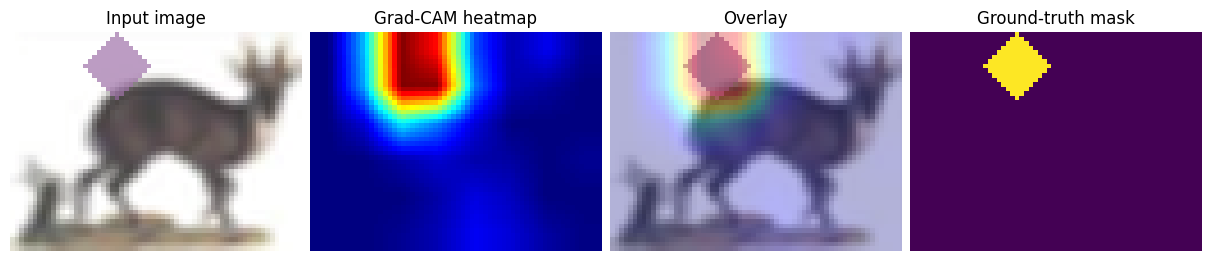

Test
0.99999994 0.0


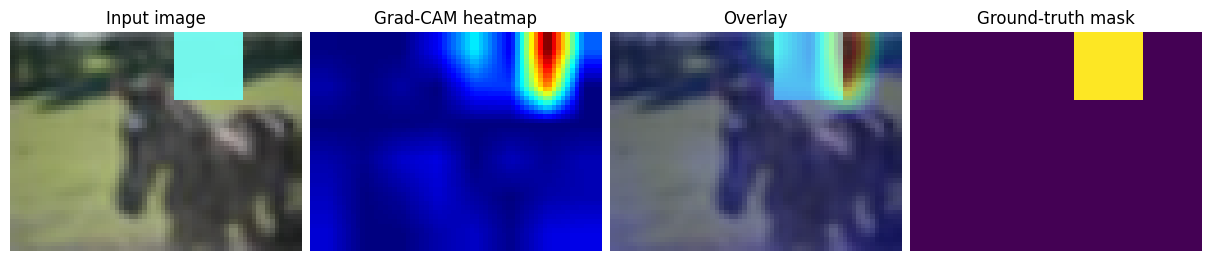

Test
1.0 0.0


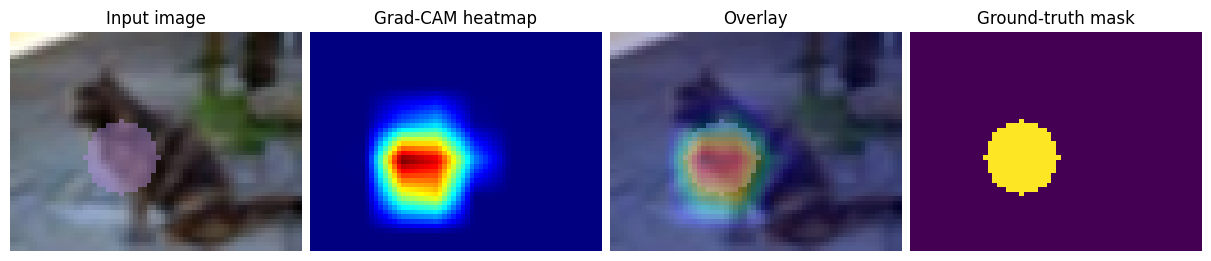

In [23]:
def example_gradcam():
    grad_cam = GradCAM(model=model, target_layers=target_layers)

    for test_idx in [3, 10, 42]:
        img, label, mask = test_dataset[test_idx]

        cam = grad_cam(img.unsqueeze(0).to(device), targets=[label])
        print(cam.max(), cam.min())
        heatmap_img = heatmap_to_rgb_image(cam.squeeze(0), 0, 1)

        show_image_row(
            {
                "Input image": inverse_transform(img),
                "Grad-CAM heatmap": heatmap_img,
                "Overlay": PIL.Image.blend(inverse_transform(img), heatmap_img, alpha=0.3),
                "Ground-truth mask": mask,
            }
        )


example_gradcam()

# 2. Segment Anything Model



## Basic usage [do not modify]
The checkpoint takes 360 MB.

In [24]:
%pip install segment-anything
!wget -nc -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [25]:
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

sam_checkpoint_path = Path("./sam_vit_b_01ec64.pth")
assert sam_checkpoint_path.exists(), "SAM checkpoint not found."

# We'll use a single global SAM model to avoid reloading it to memory multiple times.
sam_model = sam_model_registry["vit_b"](checkpoint=sam_checkpoint_path)
sam_model.to(device)
sam_predictor = SamPredictor(sam_model)

In [26]:
class BasicSamPipeline:
    def __call__(self, images: Tensor) -> Tensor:
        """
        Input: normalized images, shape (B, C=3, H, W).
        Output: masks tensor of shape (B, H, W), dtype=bool.
        """
        B, C, H, W = images.shape
        # The basic pipeline always uses a single center point for each image.
        point_coords = np.array([[(W // 2, H // 2)] for _ in range(B)])

        # The basic pipeline always uses a single foreground point, no background points.
        point_labels = np.array([[1] for _ in range(B)], dtype=np.int64)

        return self.segment(images, point_coords, point_labels)

    def segment(
        self, images: Tensor, point_coords: np.ndarray, point_labels: np.ndarray
    ) -> Tensor:
        """
        Args:
        - images: normalized images, shape (B, C=3, H, W).
        - point_coords: point coordinates within each image, shape (B, num_points, 2), format (x,y).
            Note the format is not (h,w)=(y,x), but (x,y)!
        - point_labels: point labels, shape (B, num_points), dtype int64.
            Label 1 is foreground (should be in mask), 0 is background (shouldn't be in mask).

        Returns: segmentation masks, shape (B, H, W), dtype=bool.
        """
        B, C, H, W = images.shape
        assert C == 3, f"Expected images.shape=(B, C=3, H, W), got: {images.shape}"
        num_points = point_coords.shape[1]
        assert point_coords.shape == (B, num_points, 2), f"Expected point_coords.shape=({B=}, num_points, 2), got: {point_coords.shape}"
        assert point_labels.shape == (B, num_points), f"Expected point_labels.shape=({B=}, num_points), got: {point_labels.shape}"

        results = list[Tensor]()
        for image, pt_coords, pt_labels in zip(images, point_coords, point_labels, strict=True):
            sam_predictor.set_image(np.array(inverse_transform(image)))
            masks, scores, _logits = sam_predictor.predict(
                point_coords=pt_coords, point_labels=pt_labels, multimask_output=True
            )
            best_mask = masks[np.argmax(scores)]
            results.append(torch.tensor(best_mask, dtype=torch.bool))
        return torch.stack(results)

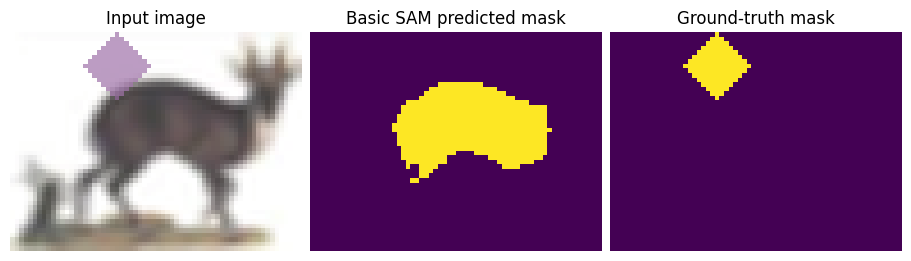

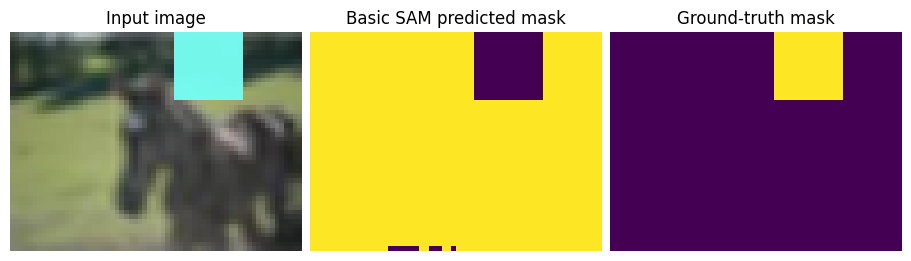

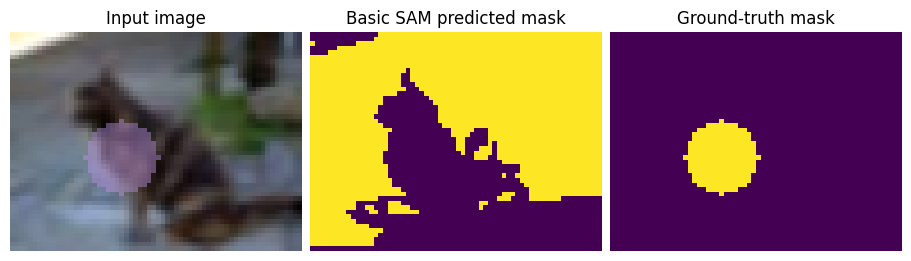

In [27]:
def example_sam():
    indices = [3, 10, 42]
    images, labels, gt_masks = next(iter(test_loader))
    images, labels, gt_masks = images[indices], labels[indices], gt_masks[indices]

    basic_pipeline = BasicSamPipeline()

    results = basic_pipeline(images).cpu()

    for image, result, gt_mask in zip(images, results, gt_masks, strict=True):
        show_image_row(
            {
                "Input image": inverse_transform(image),
                "Basic SAM predicted mask": result,
                "Ground-truth mask": gt_mask,
            }
        )


example_sam()

## Pipeline implementation and evaluation (add your code)

In [28]:
sam_eval_loader = DataLoader(test_dataset, batch_size=5, num_workers=0, pin_memory=use_accel)

Add any necessary cells regarding pipeline and evaluation.

In [29]:
class SamPipelineForegroundOnly(BasicSamPipeline):
    def __init__(self, grad_cam):
        self.grad_cam = grad_cam

    def __call__(self, images: Tensor) -> Tensor:
        """
        Input: normalized images, shape (B, C=3, H, W).
        Output: masks tensor of shape (B, H, W), dtype=bool.
        """
        B, C, H, W = images.shape
        point_coords = np.array([[self.find_foreground_point(image)] for image in images])
        point_labels = np.array([[1] for _ in range(B)], dtype=np.int64)

        return self.segment(images, point_coords, point_labels)

    def find_foreground_point(self, img):
        cam_image = self.grad_cam(img.unsqueeze(0).to(device), targets=[label])
        max_point = np.unravel_index(cam_image[0].argmax(), cam_image[0].shape)
        # Need to swap coords for SamPipeline
        return (max_point[1], max_point[0])

In [30]:
def foreground_sam():
    indices = [3, 10, 42]
    images, labels, gt_masks = next(iter(test_loader))
    images, labels, gt_masks = images[indices], labels[indices], gt_masks[indices]

    sam_gradcam = GradCAM(model=model, target_layers=target_layers)
    pipeline = SamPipelineForegroundOnly(sam_gradcam)

    results = pipeline(images).cpu()

    for image, result, gt_mask in zip(images, results, gt_masks, strict=True):
        show_image_row(
            {
                "Input image": inverse_transform(image),
                "Basic SAM predicted mask": result,
                "Ground-truth mask": gt_mask,
            }
        )


foreground_sam()

NameError: name 'label' is not defined